In [2]:
# prompt: 从test_data中读取表格数据
import pandas as pd
import os
data_dir = 'test_data'

print(f"Files in {data_dir}:")
print(os.listdir(data_dir))

pos_file_path = os.path.join(data_dir, 'AMP.csv')
neg_file_path = os.path.join(data_dir, 'non-AMP.csv')

try:
    pos_df = pd.read_csv(pos_file_path, encoding='utf-8')
    neg_df = pd.read_csv(neg_file_path, encoding='utf-8')

except FileNotFoundError:
    print(f"Error: File not found at {data_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

Files in test_data:
['AMP.csv', 'non-AMP.csv']


In [6]:
import re
command = 'python run_pretrain.py KWKLFKKIGAVVL'
result = !{command}
print(result)
for line in result:
    match = re.search(r'(\d+\.\d+)', line) # Adjust regex as needed
    if match:
        score_match = match.group(1)
print(match.group(1))

['2025-07-07 22:17:52.088838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2', 'To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.', '2025-07-07 22:17:52.090463: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.', 'Antimicrobial label prediction of the sequence   KWKLFKKIGAVVL is 0.9991.']
0.9991


In [ ]:
# prompt: 对每个数据循环执行类似!python run_pretrain.py KRIVQRIKDFLR的命令预测得到每个肽的打分，将这个打分填充到对应的pos_df 和neg_df中的predict列中，最后保存这两个表格为文件
import pandas as pd
import re
import os
os.listdir()

# Add 'predict' column initialized to NaN
pos_df['predict'] = pd.NA
neg_df['predict'] = pd.NA

# Predict scores for positive data
print("Predicting scores for positive data...")
for index, row in pos_df.iterrows():
    peptide_sequence = row['SEQUENCE']
    command = f'python run_pretrain.py {peptide_sequence}'
    result = !{command}
    score_match = None
    for line in result:
        # Example: looking for a pattern like 'Score: 0.9876' or just '0.9876'
        match = re.search(r'(\d+\.\d+)', line) # Adjust regex as needed
        if match:
            score_match = match.group(1)

    if score_match:
        pos_df.loc[index, 'predict'] = float(score_match)
        print(f"Predicted score for {peptide_sequence}: {score_match}")
    else:
        print(f"Could not find score in output for {peptide_sequence}. Output:\n{''.join(result)}")
        pos_df.loc[index, 'predict'] = pd.NA # Or some other indicator like -1 or 0

# Predict scores for negative data
print("\nPredicting scores for negative data...")
for index, row in neg_df.iterrows():
    peptide_sequence = row['Sequence']
    command = f'python run_pretrain.py {peptide_sequence}'
    print(f"Executing: {command}")
    # Capture the output
    result = !{command}
    score_match = None
    for line in result:
        match = re.search(r'(\d+\.\d+)', line) # Adjust regex as needed
        if match:
            score_match = match.group(1)

    if score_match:
        neg_df.loc[index, 'predict'] = float(score_match)
        print(f"Predicted score for {peptide_sequence}: {score_match}")
    else:
        print(f"Could not find score in output for {peptide_sequence}. Output:\n{''.join(result)}")
        neg_df.loc[index, 'predict'] = pd.NA

print("\npos_df with predictions:")
print(pos_df.head())

print("\nneg_df with predictions:")
print(neg_df.head())

# Save the updated dataframes
pos_df.to_csv(os.path.join(data_dir, 'AMP_predicted.csv'), index=False, encoding='utf-8')
neg_df.to_csv(os.path.join(data_dir, 'non-AMP_predicted.csv'), index=False, encoding='utf-8')

print(f"\nUpdated dataframes saved to {data_dir}")
print(f"Saved: AMP_predicted.csv and non-AMP_predicted.csv")

C:\Users\21198\AppData\Local\Temp\ipykernel_33056\2399843751.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[0, 1].boxplot(data_for_box, labels=['AMP', 'non-AMP'], patch_artist=True)


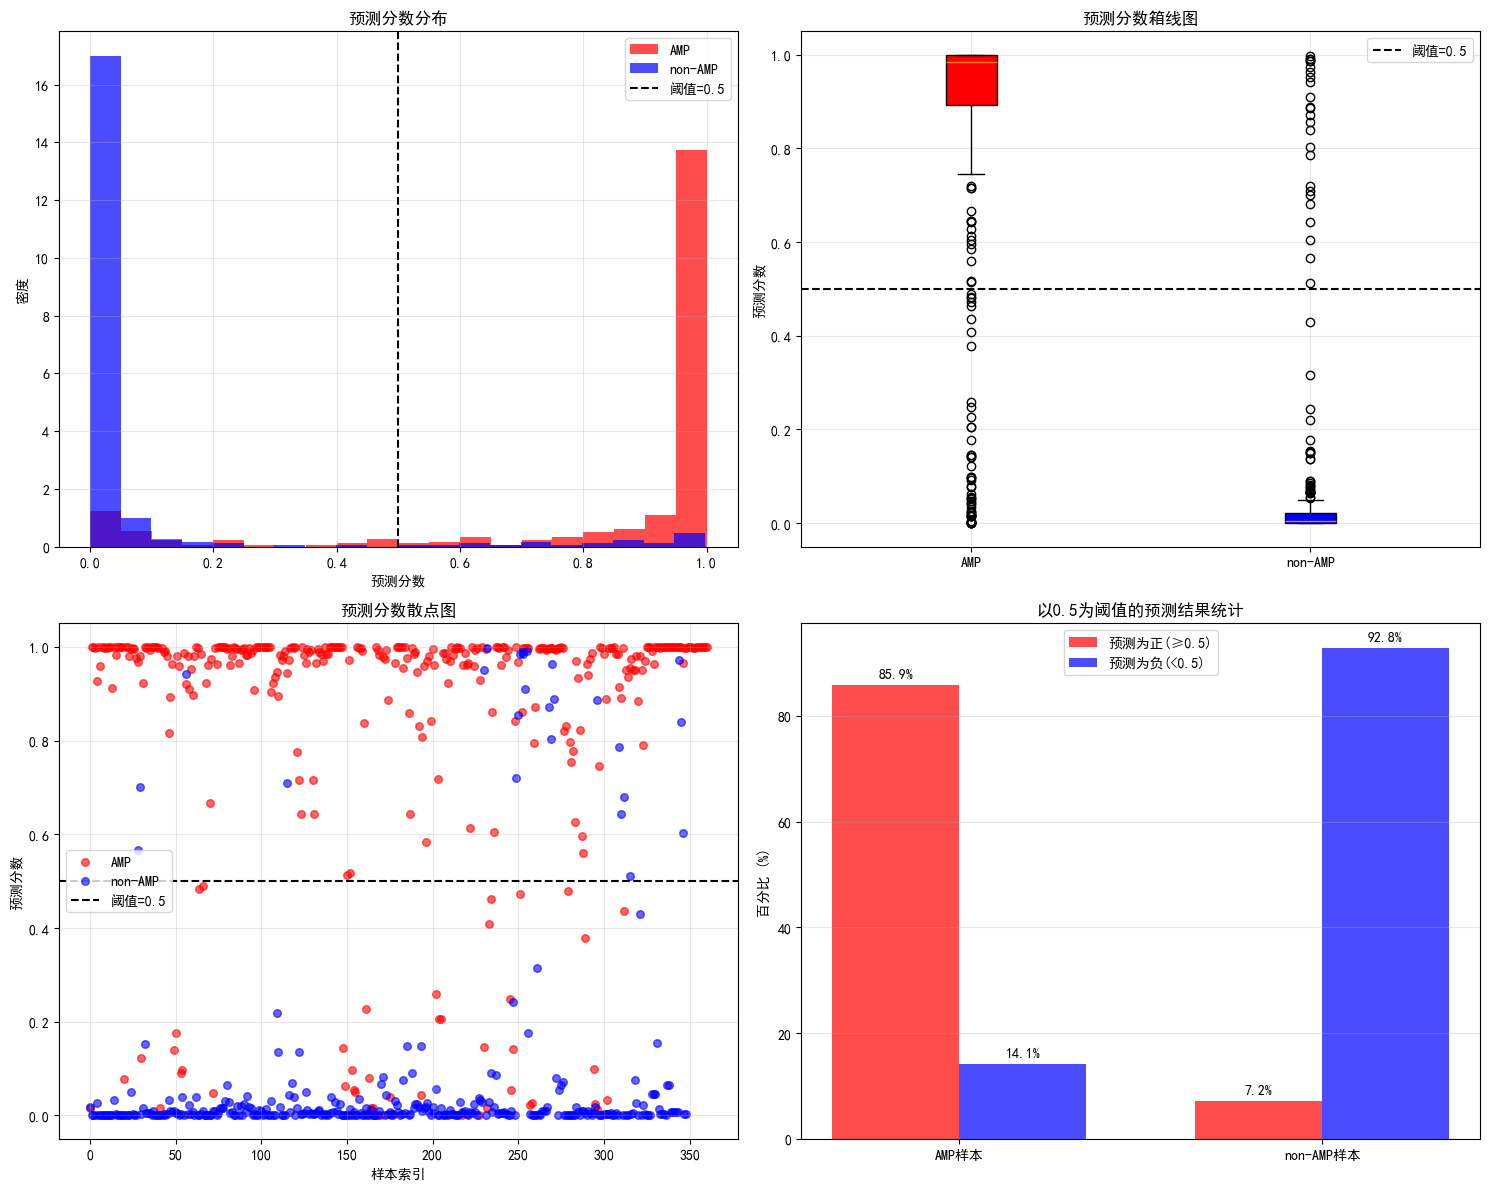

预测结果统计 (阈值 = 0.5)

AMP样本 (总数: 361):
  预测为正 (≥0.5): 310 个 (85.9%)
  预测为负 (<0.5): 51 个 (14.1%)

non-AMP样本 (总数: 349):
  预测为正 (≥0.5): 25 个 (7.2%)
  预测为负 (<0.5): 324 个 (92.8%)

⚠️  无效预测值:
  AMP样本中有 0 个无效值
  non-AMP样本中有 11 个无效值

预测分数统计:
AMP样本预测分数 - 均值: 0.839, 标准差: 0.305
non-AMP样本预测分数 - 均值: 0.076, 标准差: 0.217

模型性能指标:
准确率 (Accuracy): 0.893
精确率 (Precision): 0.925
召回率 (Recall): 0.859
F1分数: 0.891


In [11]:
# 可视化预测结果并统计阳性阴性率
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 设置图形样式
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 预测分数分布直方图 - 确保数据为数值类型
pos_valid_predictions = pd.to_numeric(pos_df['predict'], errors='coerce').dropna()
neg_valid_predictions = pd.to_numeric(neg_df['predict'], errors='coerce').dropna()

axes[0, 0].hist(pos_valid_predictions, bins=20, alpha=0.7, label='AMP', color='red', density=True)
axes[0, 0].hist(neg_valid_predictions, bins=20, alpha=0.7, label='non-AMP', color='blue', density=True)
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', label='阈值=0.5')
axes[0, 0].set_xlabel('预测分数')
axes[0, 0].set_ylabel('密度')
axes[0, 0].set_title('预测分数分布')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 箱线图 - 使用处理过的数据
data_for_box = [pos_valid_predictions, neg_valid_predictions]
box_plot = axes[0, 1].boxplot(data_for_box, labels=['AMP', 'non-AMP'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('red')
box_plot['boxes'][1].set_facecolor('blue')
axes[0, 1].axhline(y=0.5, color='black', linestyle='--', label='阈值=0.5')
axes[0, 1].set_ylabel('预测分数')
axes[0, 1].set_title('预测分数箱线图')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 散点图 - 使用处理过的数据
axes[1, 0].scatter(range(len(pos_valid_predictions)), pos_valid_predictions, alpha=0.6, color='red', label='AMP', s=30)
axes[1, 0].scatter(range(len(neg_valid_predictions)), neg_valid_predictions, alpha=0.6, color='blue', label='non-AMP', s=30)
axes[1, 0].axhline(y=0.5, color='black', linestyle='--', label='阈值=0.5')
axes[1, 0].set_xlabel('样本索引')
axes[1, 0].set_ylabel('预测分数')
axes[1, 0].set_title('预测分数散点图')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 统计结果柱状图
threshold = 0.5

# 计算统计结果 - 处理NaN值
pos_predictions = pos_df['predict'].dropna()
neg_predictions = neg_df['predict'].dropna()

# 确保所有预测值都是数值类型
pos_predictions = pd.to_numeric(pos_predictions, errors='coerce').dropna()
neg_predictions = pd.to_numeric(neg_predictions, errors='coerce').dropna()

pos_positive_rate = (pos_predictions >= threshold).mean() * 100  # AMP样本中预测为正的比例
pos_negative_rate = (pos_predictions < threshold).mean() * 100   # AMP样本中预测为负的比例

neg_positive_rate = (neg_predictions >= threshold).mean() * 100  # non-AMP样本中预测为正的比例
neg_negative_rate = (neg_predictions < threshold).mean() * 100   # non-AMP样本中预测为负的比例

categories = ['AMP样本', 'non-AMP样本']
positive_rates = [pos_positive_rate, neg_positive_rate]
negative_rates = [pos_negative_rate, neg_negative_rate]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, positive_rates, width, label='预测为正(≥0.5)', color='red', alpha=0.7)
bars2 = axes[1, 1].bar(x + width/2, negative_rates, width, label='预测为负(<0.5)', color='blue', alpha=0.7)

axes[1, 1].set_ylabel('百分比 (%)')
axes[1, 1].set_title('以0.5为阈值的预测结果统计')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 在柱状图上添加数值标签
for bar in bars1:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("="*50)
print("预测结果统计 (阈值 = 0.5)")
print("="*50)

print(f"\nAMP样本 (总数: {len(pos_predictions)}):")
print(f"  预测为正 (≥0.5): {sum(pos_predictions >= threshold)} 个 ({pos_positive_rate:.1f}%)")
print(f"  预测为负 (<0.5): {sum(pos_predictions < threshold)} 个 ({pos_negative_rate:.1f}%)")

print(f"\nnon-AMP样本 (总数: {len(neg_predictions)}):")
print(f"  预测为正 (≥0.5): {sum(neg_predictions >= threshold)} 个 ({neg_positive_rate:.1f}%)")
print(f"  预测为负 (<0.5): {sum(neg_predictions < threshold)} 个 ({neg_negative_rate:.1f}%)")

# 检查是否有无效预测值
pos_invalid_count = pos_df['predict'].isna().sum() + (pd.to_numeric(pos_df['predict'], errors='coerce').isna() & pos_df['predict'].notna()).sum()
neg_invalid_count = neg_df['predict'].isna().sum() + (pd.to_numeric(neg_df['predict'], errors='coerce').isna() & neg_df['predict'].notna()).sum()

if pos_invalid_count > 0 or neg_invalid_count > 0:
    print(f"\n⚠️  无效预测值:")
    print(f"  AMP样本中有 {pos_invalid_count} 个无效值")
    print(f"  non-AMP样本中有 {neg_invalid_count} 个无效值")

print(f"\n预测分数统计:")
print(f"AMP样本预测分数 - 均值: {pos_predictions.mean():.3f}, 标准差: {pos_predictions.std():.3f}")
print(f"non-AMP样本预测分数 - 均值: {neg_predictions.mean():.3f}, 标准差: {neg_predictions.std():.3f}")

# 计算模型性能指标
true_positive = sum(pos_predictions >= threshold)  # 真正例：AMP样本预测为正
false_negative = sum(pos_predictions < threshold)  # 假负例：AMP样本预测为负
false_positive = sum(neg_predictions >= threshold) # 假正例：non-AMP样本预测为正
true_negative = sum(neg_predictions < threshold)   # 真负例：non-AMP样本预测为负

accuracy = (true_positive + true_negative) / (len(pos_predictions) + len(neg_predictions))
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n模型性能指标:")
print(f"准确率 (Accuracy): {accuracy:.3f}")
print(f"精确率 (Precision): {precision:.3f}")
print(f"召回率 (Recall): {recall:.3f}")
print(f"F1分数: {f1_score:.3f}")
print("="*50)